In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# **MLP for language modelling**

# follow Bengio et al 2003 - A Neural Probabilistic Language Model

not first paper to do this - use MLP to predict next token in a sequence 

but nicely written and often cited to stand in for this idea

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

### Learning joint probabilit function of sequences of words is difficult due to the CURSE OF DIMENSIONALITY



To address this the propose mode (NB their model is word level ours is character level)

Take each input word - and embed each word into a m dimensional input vector - embedded into 30D space

In beginning initialized randomly, but then these positions are tuned

Words with similiar meaning will end up closer together

Can better deal with "out of distribution" phrases 

C = embedds the inputs - the ith row is the embedding of the ith word 

x = embedding = (one_hot(word)) @ C - technically a matrix mul but also jsut an index as word is oe_hot encoded

THen into a neural network

The size of this NN hidden layer is a HYPER PARAMETER

Each neuron is however fully connected to the n*m input values (n words input which are embedded into m sized vecotrs = n * m inputs)

Then we tanh each neuron

THen feed it into a output layer which has |V| (where V is number of classes you are potentially predicting onto) neurons - most computation is this step 

THen this output is softmaxed

Then everything is optimized using backprop


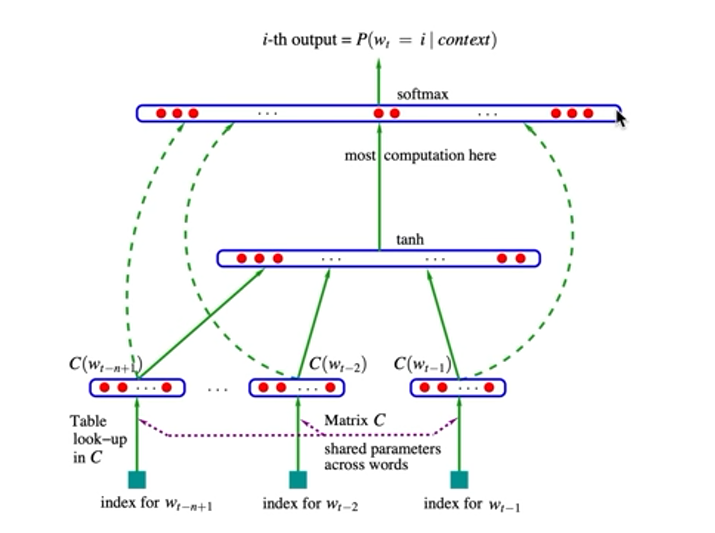




# LETS BEGIN

In [2]:
# import words
words = open('makemore/names.txt','r').read().splitlines()
len(words)

32033

In [3]:
#build "vocabulary" of characters and mapping to and from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(["."] + chars)}
# stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [356]:
# build the dataset
block_size = 3 # how many chars do we take to predict the next one (context length)

X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0]*block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context),"-->",itos[ix])
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [357]:
X.shape, X.dtype

(torch.Size([32, 3]), torch.int64)

# Building embedding look-up table

In paper 17000 words into 30 dimensional space

Here 

27 characters into 2 dimensions

In [63]:
g = torch.Generator().manual_seed(123)
C = torch.rand((27,2), generator = g)

In [198]:
#to acces the encoded row - can create a one_hot encoding of hte integer and then matrix multiply
# # or simple index the ith row :) 

#print(F.one_hot(torch.tensor(X), num_classes= 27).float() @ C == C[X] )

print(F.one_hot(torch.tensor(X), num_classes= 27).float().shape)
print(C.shape)
print( (F.one_hot(torch.tensor(X), num_classes= 27).float() @ C ).shape)

torch.Size([32, 3, 27])
torch.Size([27, 2])
torch.Size([32, 3, 2])


C:\Users\bruno\AppData\Local\Temp\ipykernel_14376\3305809382.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(F.one_hot(torch.tensor(X), num_classes= 27).float().shape)
C:\Users\bruno\AppData\Local\Temp\ipykernel_14376\3305809382.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print( (F.one_hot(torch.tensor(X), num_classes= 27).float() @ C ).shape)


In [111]:
# how to we simultaneouslt embed these integers stored in array x

#luckily pytorch indexing is very powerful so can just index using x
#C[[5,5,7]] #reutrns row 5 twice and row 7
# can also embedd with 2D tensor - 
#first dimension will be 
emb = C[X] #3D tensor #32 inputs of 3x2 matrixes one matrix for each context or for each of hte 32x2 inputs returns a vector so adds another dimension of size 2 (size of embedding vector)

# print(C[X].shape)
# print(X[13,2])
# print(C[X][13,2])
# print(C[0])
#  TLDR pytorch indexing is awesome

# Reshaping input to feed context in at once (concatenate them)

In [148]:
#many ways of doing this - often the case in torch

#.cat()
#print(emb[:, 0, :])
#torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), dim = 1) #but would need to change index length

#.unbind()
#torch.cat(torch.unbind(emb, dim = 1),dim = 1)

#emb = emb.reshape([emb.shape[0],-1])
#emb.shape

emb.view(32,6)

tensor([[0.2961, 0.5166, 0.2961, 0.5166, 0.2961, 0.5166],
        [0.2961, 0.5166, 0.2961, 0.5166, 0.1841, 0.7264],
        [0.2961, 0.5166, 0.1841, 0.7264, 0.2745, 0.6584],
        [0.1841, 0.7264, 0.2745, 0.6584, 0.2745, 0.6584],
        [0.2745, 0.6584, 0.2745, 0.6584, 0.2961, 0.5166],
        [0.2961, 0.5166, 0.2961, 0.5166, 0.2961, 0.5166],
        [0.2961, 0.5166, 0.2961, 0.5166, 0.8993, 0.0390],
        [0.2961, 0.5166, 0.8993, 0.0390, 0.6367, 0.9826],
        [0.8993, 0.0390, 0.6367, 0.9826, 0.1186, 0.8274],
        [0.6367, 0.9826, 0.1186, 0.8274, 0.4545, 0.9737],
        [0.1186, 0.8274, 0.4545, 0.9737, 0.1186, 0.8274],
        [0.4545, 0.9737, 0.1186, 0.8274, 0.2961, 0.5166],
        [0.2961, 0.5166, 0.2961, 0.5166, 0.2961, 0.5166],
        [0.2961, 0.5166, 0.2961, 0.5166, 0.2961, 0.5166],
        [0.2961, 0.5166, 0.2961, 0.5166, 0.4545, 0.9737],
        [0.2961, 0.5166, 0.4545, 0.9737, 0.2961, 0.5166],
        [0.2961, 0.5166, 0.2961, 0.5166, 0.2961, 0.5166],
        [0.296

### **best way to do this - plus some insights into the internals of tensors**


In [147]:
# a = torch.arange(18)
# print(a)
# a.shape

# # we can easily represent this as different sized n-dimensional tensors
# #print(a.view((2,9)))
# #a.view((3,3,2)) #fills in reverse dimensions - rows hten columns then last dimension

# #.view() is extrmely efficient

# #each tensor has an underlying storage
# a.storage()

# a.view((2,9))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

I always find it a bit ocnfusing that hte number of columns is the size of the rows - so difficult to express some ideas about order or operations

# Constructing the hidden layer

In [159]:

# matrix (input, outputs)
n = 100 #number of neurons in hte hidden layer
W1 = torch.randn((6,n)) #input = size of context = n * m = 3 * 2 = 6
b1 = torch.randn(n) #since b1 is 1D (row) will be added elementwise to each row

#h = emb.view(32,6) @ W1 + b1 #will not work as embeddings are stacked into the input tensor 
# since b1 is 1D 
# 32, 100
#    ,100 
#see above so broadcasting will create new dimension in blank space, and then copy to match other tensor 

h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape



torch.Size([32, 100])

# Main layer

In [163]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

# extracting logits

In [164]:
logits = h @ W2 + b2 
logits.shape

torch.Size([32, 27])

# softmax

In [173]:
counts = logits.exp()
print(counts.shape)
print(counts.sum(dim = 1,keepdims = True).shape)
#remember broadcasting rule - need to keep the sums as a row vector
prob = counts / counts.sum(dim = 1,keepdims = True)

torch.Size([32, 27])
torch.Size([32, 1])


# loss

Index into rows of prob and pluck out probability assigned to hte actual y


In [183]:
likelihoods = prob[np.arange(prob.shape[0]),Y] #makes sense :)
nll = -likelihoods.log().mean()
nll

tensor(11.1915)

# Cleaning it up

In [191]:
print(X.shape, Y.shape)
print(X[0])

torch.Size([32, 3]) torch.Size([32])
tensor([0, 0, 0])


In [216]:

#initialize encoding vector 
C = torch.randn((27,2)) #can choose how many dimensions to embed into

#can use matrix multiplication or just index using the integers of x
emb = C[X]
print(emb.shape)

#context lenght = 3 so need to concatenate the embeed vectors
print(emb.view(-1,6).shape)

#hidden layer with n neurons
n = 100
W1 = torch.randn((6,100))
b1 = torch.randn(100)
h = torch.tanh(emb.view((-1,6)) @ W1 + b1)
print(h.shape)

#biggest step hidden to output
W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + b2

#softmax
counts = logits.exp()
prob = counts / counts.sum(dim = 1, keepdims = True)
print(prob.shape)

#loss
print(Y.shape)
loss = -prob[np.arange(len(Y)),Y].log().mean() #negative log likelihood
loss


torch.Size([32, 3, 2])
torch.Size([32, 6])
torch.Size([32, 100])
torch.Size([32, 27])
torch.Size([32])


tensor(-19.2634)

# fully meanual clean code

In [227]:
#fully clean code
g = torch.Generator().manual_seed(32)
C = torch.randn((27,2),generator = g)
W1 = torch.randn((6,100),generator = g)
b1 = torch.randn(100,generator = g)
W2 = torch.randn((100,27),generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C,W1,b1,W2,b2]

In [228]:
sum(p.nelement() for p in parameters)

3481

In [223]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(dim = 1, keepdims = True)
loss = -prob[np.arange(len(Y)),Y].log().mean()
loss

tensor(18.8451)

# now using some premade functions

In [226]:
#Pytroch creates clustered fused kernel rather building up all of the intermediate tensors (what happens when we do it manually) which is more efficient forward and backward
# also .cross_entropy is numerically more well behaved - doing .exp() and .log() manualy can make you run into issues if numbers are very large for exp -> inf (or 0 for log - less relevant)
# pytorch offsets the logits by a value to make it work - does not affect outcome because of the final normalization step
# pytorch substracts maximum number - very negative numbers are well behaved :)
loss = F.cross_entropy(logits, Y)

# Final


In [275]:
# build the dataset
block_size = 3 # how many chars do we take to predict the next one (context length)

X, Y = [], []

for w in words[:]:
    #print(w)
    context = [0]*block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print("".join(itos[i] for i in context),"-->",itos[ix])
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [276]:
#fully clean code
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator = g)
W1 = torch.randn((6,100),generator = g)
b1 = torch.randn(100,generator = g)
W2 = torch.randn((100,27),generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C,W1,b1,W2,b2]

In [277]:
for p in parameters:
    p.requires_grad = True

## implement stochastic gradient descence

working with batches of data

This will make the "quality" of the gradient lower - but will speed up compute, interesting tradeoff

In [272]:
#learning_rate tuning
# step through exponent - JUST LIKE I DID BABY
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
#lrs


In [273]:
losses = []

for i in range(1000):
    #minibatch construction
    ix = torch.randint(0,X.shape[0],(32,)) #?with replacement

    #forward pass
    emb = C[X[ix]] #X is indexed to select minbatch
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(f"{loss.item()=}")
    #losses.append(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    learning_rate = lrs[i]
    for p in parameters:
        p.data -= learning_rate * p.grad

    #track stats
    #lri.append(learning_rate)
    losses.append(loss.item())


# this works right now as we are just overfitting 32 examples
#Karpathy says do this everytime you train a netwrok - overfit a single batch to check everything is working well

#loss cant get to 0 as there are some duplicate inputs with different outputs




loss.item()=19.83896827697754
loss.item()=19.55849266052246
loss.item()=18.42321014404297
loss.item()=19.212139129638672
loss.item()=16.752426147460938
loss.item()=16.828475952148438
loss.item()=17.162662506103516
loss.item()=17.916833877563477
loss.item()=20.556312561035156
loss.item()=22.573484420776367
loss.item()=18.207002639770508
loss.item()=19.846786499023438
loss.item()=21.234453201293945
loss.item()=16.758970260620117
loss.item()=20.813459396362305
loss.item()=18.435148239135742
loss.item()=17.617517471313477
loss.item()=22.19875717163086
loss.item()=18.130126953125
loss.item()=18.687082290649414
loss.item()=18.299726486206055
loss.item()=19.456392288208008
loss.item()=20.799734115600586
loss.item()=19.2922420501709
loss.item()=19.05388069152832
loss.item()=20.81923484802246
loss.item()=21.242284774780273
loss.item()=23.234066009521484
loss.item()=19.290496826171875
loss.item()=20.929874420166016
loss.item()=18.687604904174805
loss.item()=17.506328582763672
loss.item()=17.0440

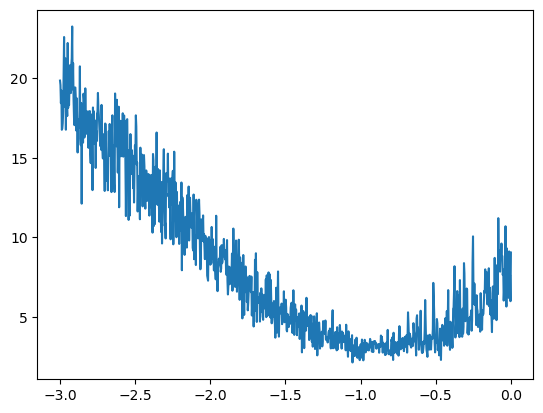

In [274]:
plt.plot(lre,losses)

In [258]:
# evaluate full loss
emb = C[X] #X is indexed to select minbatch
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f"{loss.item()=}")


loss.item()=2.5447299480438232


# we dont know if we are stepping too slow ot roo fast - so need to determine learning rate

# Karpathy heuristic
#Manually check lower and upper bounds of reasonable losses
#lower bound = improves but slowly
# upper bound = loss explodes - doesnt optimize

# step across thsi bound on an exponential scale

#then train the network but iterating through these learning rates

#plot learning rate vs loss

#pick a learning rate around the valley

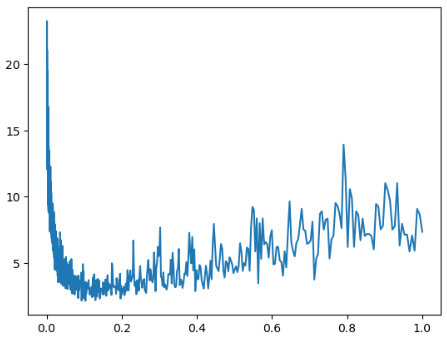

plotting exponents on x axis instead

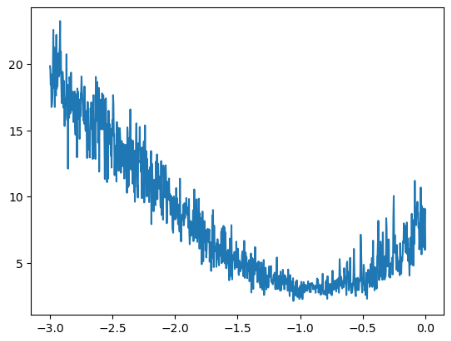



In [289]:
# using this newly found optimum learning rate

#and then some manual learning rate decay (often by a factor of 10) once it feels like plateu

In [ ]:
losses = []

In [286]:
#make sure you re-initilize hte parameters

for i in range(10000):
    #minibatch construction
    ix = torch.randint(0,X.shape[0],(32,)) #?with replacement

    #forward pass
    emb = C[X[ix]] #X is indexed to select minbatch
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(f"{loss.item()=}")
    losses.append(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    learning_rate = 10**-2
    for p in parameters:
        p.data -= learning_rate * p.grad



In [290]:
# evaluate full loss
emb = C[X] #X is indexed to select minbatch
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f"{loss.item()=}")


loss.item()=2.2301418781280518


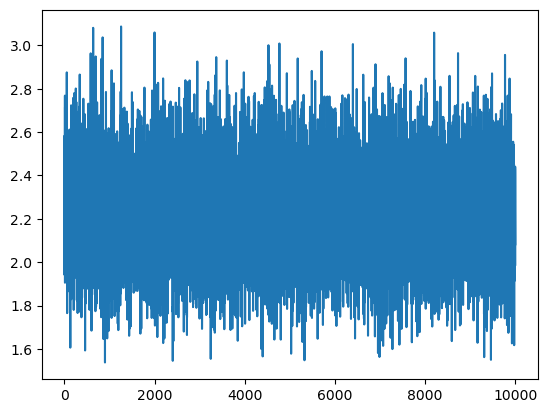

In [288]:
plt.plot(losses)

# splitting into test, train splits to avoid overfitting

The larger the network the more able it is to overfit

Split into 3 splits

1. Training (~80%) - parameters
2. Dev/validation (~10%) - hyperparameters (can also do CV)
3. Test (~10%) - Evalutate performance of hte model at the end (only do this sparingly othewise you risk overfitting to it)

In [5]:
  # build the dataset

def build_dataset(words):
    block_size = 3 # how many chars do we take to predict the next one (context length)
    X, Y = [], []

    for w in words[:]:
        #print(w)
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context),"-->",itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    X.shape, Y.shape
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [65]:
#fully clean code
g = torch.Generator().manual_seed(214748364)
C = torch.randn((27,2),generator = g)
W1 = torch.randn((6,300),generator = g)
b1 = torch.randn(300,generator = g)
W2 = torch.randn((300,27),generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True

In [66]:
sum(p.nelement() for p in parameters)

10281

In [70]:
#%%capture #stops all outputs#
#prevent plots from plotting
#plt.ioff() #stops pyplot outputs

#training network and visualizing embeddings

lossi = []

for epoch in range(100000):
    #minibatch construction
    ix = torch.randint(0,Xtr.shape[0],(64,)) #?with replacement

    #forward pass
    emb = C[Xtr[ix]] #X is indexed to select minbatch
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f"{loss.item()=}")
    #losses.append(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    #learning_rate = 10**-2
    #learning_rate = lrs[i]
    learning_rate = 10**-2
    for p in parameters:
        p.data -= learning_rate * p.grad

    #track stats
    #lri.append(learning_rate)
    lossi.append(loss.item())

    #adding in
    if epoch % 1000 == 0:  #remainer check
        
        print(epoch)
        print(f"{loss.item()=}")
        
        fig, ax = plt.subplots()
        fig.set_size_inches(8,8)
        ax.scatter(C[:,0].data,C[:,1].data,s = 200)
        for i in range(C.shape[0]):
            ax.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center", color = "white")
        ax.grid("minor")
        ax.set_title(f"epoch {epoch}")
        fig.savefig(f"plots/epoch_{epoch}.png")
        plt.close() #close plots to stop them living in memory
        

        
        


# this works right now as we are just overfitting 32 examples
#Karpathy says do this everytime you train a netwrok - overfit a single batch to check everything is working well

#loss cant get to 0 as there are some duplicate inputs with different outputs




0
loss.item()=24.712905883789062
1000
loss.item()=3.0881898403167725
2000
loss.item()=2.8194546699523926
3000
loss.item()=2.6921005249023438
4000
loss.item()=2.7242050170898438
5000
loss.item()=2.7641046047210693
6000
loss.item()=2.5774917602539062
7000
loss.item()=2.6467440128326416
8000
loss.item()=2.6018455028533936
9000
loss.item()=2.4999608993530273
10000
loss.item()=2.3052542209625244
11000
loss.item()=3.0554027557373047
12000
loss.item()=2.566066026687622
13000
loss.item()=2.2449636459350586
14000
loss.item()=2.4035425186157227
15000
loss.item()=2.704179525375366
16000
loss.item()=2.505556344985962
17000
loss.item()=2.383704662322998
18000
loss.item()=2.4480037689208984
19000
loss.item()=2.469567060470581
20000
loss.item()=2.2135043144226074
21000
loss.item()=2.4155831336975098
22000
loss.item()=2.5170583724975586
23000
loss.item()=2.4623799324035645
24000
loss.item()=2.56258225440979
25000
loss.item()=2.4283056259155273
26000
loss.item()=2.5498478412628174
27000
loss.item()=2.3

In [62]:
import imageio

In [72]:
#creating plot
with imageio.get_writer("line.gif",mode = "i") as writer: #get_writer creates a new file "line.gif" and mode simply tells it we are giving it images as an input
    for i in range(0,100000,1000):
        image = imageio.imread(f"plots/epoch_{i}.png") #read image
        writer.append_data(image) #writes to the file specified above

C:\Users\bruno\AppData\Local\Temp\ipykernel_1996\3758789754.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f"plots/epoch_{i}.png") #read image


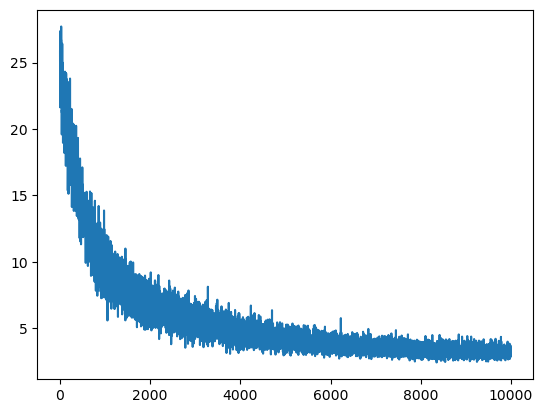

In [10]:
plt.plot(lossi)

In [22]:
# testing on developement set
 #forward pass
emb = C[Xtr] #X is indexed to select minbatch
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f"{loss.item()=}")
    #losses.append(loss.item())

loss.item()=2.4186065196990967


In [23]:
# testing on developement set
 #forward pass
emb = C[Xdev] #X is indexed to select minbatch
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"{loss.item()=}")
    #losses.append(loss.item())

loss.item()=2.413642406463623


If training and dev loss are equal - not overfitting - actualy underfitting, so makign a bigger net will help

Hyperparameters:

1. Learning rate
2. Batch size
3. architecture    
    a. hidden layer size
    b. Number of embedded dimensions


Need to experiment to find what is most important

# Visualize the embeddings


In [71]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data,C[:,1].data,s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid("minor")
#plt.show()

# embed into 10 dimensions

In [ ]:
losses = []

for i in range(1000):
    #minibatch construction
    ix = torch.randint(0,X.shape[0],(32,)) #?with replacement

    #forward pass
    emb = C[X[ix]] #X is indexed to select minbatch
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(f"{loss.item()=}")
    #losses.append(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    learning_rate = lrs[i]
    for p in parameters:
        p.data -= learning_rate * p.grad

    #track stats
    #lri.append(learning_rate)
    losses.append(loss.item())


# this works right now as we are just overfitting 32 examples
#Karpathy says do this everytime you train a netwrok - overfit a single batch to check everything is working well

#loss cant get to 0 as there are some duplicate inputs with different outputs

